In [1]:
import pathlib
import pandas as pd
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))
from transects import Transects
from reports import Reports
import pathlib
from results import LBLResults, YOLOResults 

In [ ]:
collect_id = "label data inference 4096 all"
PATHS = {
    "annual_inference_assmt" : r"Z:\__AdvancedTechnologyBackup\03_InferenceResults\GobyFinder\inference_assessment_all_clean.pkl",
    "weights": r"Z:\__AdvancedTechnologyBackup\06_ModelWeights\GobyFinderAUV2048.pt",
    "poly_lbl_assmt": r"Z:\__AdvancedTechnologyBackup\07_Database\FishScaleLabelAssessment\2020-2023_assessment_confirmedfish.pkl",
    "op_table": r"Z:\__AdvancedTechnologyBackup\07_Database\OP_TABLE.xlsx",
    "metadata": r"Z:\__AdvancedTechnologyBackup\07_Database\MetadataCombined\all_annotated_meta_splits_20250915.csv",
    "img_directory": r"Z:\__Organized_Directories_InProgress\2024_UnpackedCollects\20240618_001_Iver3069_ABS2\PrimaryImages",
}
PATHS.update({
    "new_inference_assmt": os.path.join(PATHS["run_folder"], "inference_results.csv"),
    "fndf": os.path.join(PATHS["run_folder"], "false_negatives.csv"),
    "lbl_box_results": os.path.join(PATHS["run_folder"], "label_box_results.csv"),
    "scores_df": os.path.join(PATHS["run_folder"], "scores.csv"),
    "lbl_df": os.path.join(PATHS["run_folder"], "labels.csv"),
    "pred_df": os.path.join(PATHS["run_folder"], "predictions.csv"),
})    
paths = {key: pathlib.Path(value) for key, value in PATHS.items()}

In [ ]:
def process_and_save_results(paths=paths, iou_tp=0.5):
    """Read label/prediction CSVs, deduplicate/save via provided helpers, compute scores and label-box results.

    Returns a dict with paths to generated files and the lblres DataFrame.
    """
    run_folder = pathlib.Path(paths["run_folder"])
    run_folder.mkdir(parents=True, exist_ok=True)

    # Read original CSVs
    lbl_df_orig = pd.read_csv(paths["lbl_df"], index_col=0)
    pred_df_orig = pd.read_csv(paths["pred_df"], index_col=0)

    # Output paths (kept similar to the original naming)
    pred_csv_path = run_folder / "predictions_t.csv"
    lbl_csv_path = run_folder / "labels_t.csv"
    scores_csv_path = run_folder / "scores_t.csv"
    lbl_box_out_path = run_folder / "label_box_results_t.csv"

    # Save using the provided helper functions (they handle deduplication)
    Reports.save_labels_to_csv(lbl_df_orig, str(lbl_csv_path))
    Reports.save_predictions_to_csv(pred_df_orig, str(pred_csv_path))

    # Read back the cleaned files
    lbl_df = pd.read_csv(lbl_csv_path, index_col=0)
    pred_df = pd.read_csv(pred_csv_path, index_col=0)

    # Compute scores and save
    scores_df = Reports.scores_df(lbl_df, pred_df, iou_tp=0.5)
    scores_df.to_csv(scores_csv_path)

    # Generate label-box results
    output = LBLResults(paths["metadata"], str(lbl_csv_path), "", paths["op_table"], find_closest=False)
    lblres = output.lbl_results()

    # Save label-box results
    print(f"saving label box results to csv: {lbl_box_out_path}")
    lblres.to_csv(lbl_box_out_path, index=False)

    return lblres
# Execute the refactored workflow
results = process_and_save_results(paths=paths)

In [29]:
# import assessment and label results
# collect_id = '20240804_001_Iver3069_ABS2'
collect_id = '20240618_001_Iver3069_ABS2'
# Usable image list based on metadata
# usable_images = pd.read_csv(PATHS["metadata"], usecols=["Filename", "Usability", "collect_id"])
# usable_images = usable_images[usable_images.collect_id == collect_id]
# usable_images = usable_images[usable_images.Usability=="Usable"].Filename.tolist()

# Load inference assessment and label box results
# This is the inference results from the runResults.py script
# inference_assmt = pd.read_csv(PATHS["new_inference_assmt"])
# inference_assmt = inference_assmt[inference_assmt.Filename.isin(usable_images)]
inference_assmt = pd.read_pickle(PATHS["annual_inference_assmt"])
inference_assmt = inference_assmt[inference_assmt.collect_id == collect_id]
# inference_assmt = inference_assmt[inference_assmt.conf >= confidence_threshold].copy()
print("inference results confidence threshold", f"{inference_assmt[inference_assmt.conf_pass==1].conf.min():0.2f}")
# Load the label box results also from the runResults.py script
# lblres = pd.read_csv(PATHS["lbl_box_results"], index_col=0)
# lblres = lblres[lblres.Filename.isin(usable_images)]

# Load the FishScale polynomial assessment where full segmentation was required
# poly_lbl_assmt = pd.read_pickle(PATHS["poly_lbl_assmt"])
# poly_lbl_assmt = poly_lbl_assmt[poly_lbl_assmt.Filename.isin(usable_images)]

inference results confidence threshold 0.28


In [30]:
# filter inference and label results for transects
print("original shape", inference_assmt.shape)

# Configuration for subsampling
frac = 0.25  # Desired subsample fraction

# --- Step 1: Get the unique, ordered list of images ---
# NOTE: The order of unique() might not be sequential. We assume the order 
# in the DataFrame is sequential along the transect.
unique_filenames = inference_assmt.Filename.unique()
num_unique_images = len(unique_filenames)
print(f"Number of unique images: {num_unique_images}")

# --- Step 2: Calculate the target number and step size ---
# Target number of images (n)
n = max(1, int(frac * num_unique_images))

# Calculate the step size to select n evenly spaced images.
# Example: If num_unique_images=100 and n=5, step_size is 20.
step_size = num_unique_images // n 

# --- Step 3: Select the evenly spaced indices ---
# Indices for selection: starts at 0, steps by step_size, up to the end.
# We explicitly convert the NumPy array to a Series to use iloc easily.
selected_indices = range(0, num_unique_images, step_size)
even_subsample_images = pd.Series(unique_filenames).iloc[selected_indices].tolist()

# --- Step 4: Filter the full inference data ---
# Filter the inference data to keep *all* detections associated with the selected images.
subsample = inference_assmt[inference_assmt.Filename.isin(even_subsample_images)].copy()

# Print results
print(f"Even Subsampling at {frac*100:0.0f}%: {len(even_subsample_images)} images, total detections: {subsample.shape[0]}")

original shape (13943, 36)
Number of unique images: 2681
Even Subsampling at 25%: 671 images, total detections: 3493


In [47]:
img_directory = r"Z:\__Organized_Directories_InProgress\2024_UnpackedCollects\20240618_001_Iver3069_ABS2\PrimaryImages"
subsample_fn = subsample.Filename.unique()
print(f"Subsampled filenames: {len(subsample_fn)} unique images")
unpacked_filenames = os.listdir(img_directory)
unpacked_filenames = list(map(lambda x: x.split(".")[0], unpacked_filenames))
assert len(list(set(subsample_fn).intersection(unpacked_filenames))) == len(subsample_fn), "Subsampled filenames do not match unpacked filenames."

Subsampled filenames: 671 unique images


In [7]:
# lblres_transects = lblres
# poly_assmt_transects = poly_lbl_assmt
# scores_df = pd.read_csv(PATHS["scores_df"], index_col=0)
# scores_df = scores_df[scores_df.Filename.isin(infer_transects.Filename.to_list())]
# tpd = scores_df[scores_df.tp==1].detect_id
# fpd = scores_df[scores_df.fp==1].detect_id
# fndf = pd.read_csv(PATHS["fndf"])
# fnid = fndf.ground_truth_id

In [31]:
# --- Total Weights (g) ---
filt_wt = 80
# total_lbl_box_weight = lblres_transects[lblres_transects.box_DL_weight_g_corr<=filt_wt].box_DL_weight_g_corr.sum()  # Filter out weights > 80g
# total_poly_weight = poly_assmt_transects[poly_assmt_transects.Poly_Corr_weight_g<=filt_wt].Poly_Corr_weight_g.sum()
# Total Inferred Weight (g) - all detections in the inference results
total_infer_weight = inference_assmt[inference_assmt.box_DL_weight_g_corr<=filt_wt].box_DL_weight_g_corr.sum()
subsample_infer_weight = subsample[subsample.box_DL_weight_g_corr<=filt_wt].box_DL_weight_g_corr.sum()

# --- Performance Weights (g) ---
# True Positives (inferred detections that matched a ground truth)
# true_fish_weight = inference_assmt[inference_assmt.detect_id.isin(tpd.to_list())]
# true_fish_weight = true_fish_weight[true_fish_weight.box_DL_weight_g_corr<=filt_wt].box_DL_weight_g_corr.sum()
# # False Positives (inferred detections that did not match a ground truth)
# false_fish_weight = inference_assmt[inference_assmt.detect_id.isin(fpd.to_list())]
# false_fish_weight = false_fish_weight[false_fish_weight.box_DL_weight_g_corr<=filt_wt].box_DL_weight_g_corr.sum()
# # Missed (False Negatives - ground truth boxes that were NOT detected)
# missed_fish_weight = lblres_transects[lblres_transects.ground_truth_id.isin(fnid.to_list())]
# missed_fish_weight = missed_fish_weight[missed_fish_weight.box_DL_weight_g_corr<=filt_wt].box_DL_weight_g_corr.sum()

# --- Average Biomass Density (g/m^2) ---
infer_biomass_df = Transects.biomass_transects(inference_assmt)
avg_infer_biomass = infer_biomass_df.biomass_g_p_m2.mean()

# --- Subsample biomass density (g/m^2) ---
subsample_biomass_df = Transects.biomass_transects(subsample)
avg_subsample_biomass = subsample_biomass_df.biomass_g_p_m2.mean()

# lblbox_biomass_df = Transects.biomass_transects(lblres_transects)
# avg_lblbox_biomass = lblbox_biomass_df.biomass_g_p_m2.mean()

# lblpoly_biomass_df = Transects.biomass_transects(poly_assmt_transects)
# avg_lblpoly_biomass = lblpoly_biomass_df.biomass_g_p_m2.mean()


# 2. Create the Summary Table Data Structure

# data = {
#     'Metric': [
#         "confidence_threshold"
#         "Total Labeled Box Weight",
#         "Total Labeled Polygon Weight",
#         "Total Inferred Weight",
#         "---",
#         "Inferred True Positive Weight",
#         "Inferred False Positive Weight",
#         "Labeled Missed Weight (False Neg.)",
#         "---",
#         "Average Inferred Biomass Density",
#         "Average Labeled Box Biomass Density",
#         "Average Labeled Polygon Biomass Density"
#     ],
#     'Value': [
#         confidence_threshold if 'confidence_threshold' in locals() else "None",
#         total_lbl_box_weight if 'total_lbl_box_weight' in locals() else "None",
#         total_poly_weight if 'total_poly_weight' in locals() else "None",
#         total_infer_weight if 'total_infer_weight' in locals() else "None",
#         None, # Separator
#         true_fish_weight if 'true_fish_weight' in locals() else "None",
#         false_fish_weight if 'false_fish_weight' in locals() else "None",
#         missed_fish_weight if 'missed_fish_weight' in locals() else "None",
#         None, # Separator
#         avg_infer_biomass if 'avg_infer_biomass' in locals() else "None",
#         avg_lblbox_biomass if 'avg_lblbox_biomass' in locals() else "None",
#         avg_lblpoly_biomass if 'avg_lblpoly_biomass' in locals() else "None"
#     ],
#     'Units': [
#         "g", "g", "g", "", "g", "g", "g", "", "g/m²", "g/m²", "g/m²"
#     ]
# }

# # 3. Create and Format DataFrame
# df = pd.DataFrame(data)

# # Format the 'Value' column
# # Use fillna('') to handle the None separators
# df['Value'] = df['Value'].apply(lambda x: f"{x:,.2f}" if pd.notna(x) else '')

# # Replace separators with a blank row for clarity
# df = df.replace('---', '')


# # Example Usage (replace with your actual call):
# display(df) # Use this in Jupyter/Colab


In [32]:
print("average biomass", avg_infer_biomass)
print("average subsample biomass", avg_subsample_biomass)

average biomass 5.664501583717685
average subsample biomass 5.586633072511262


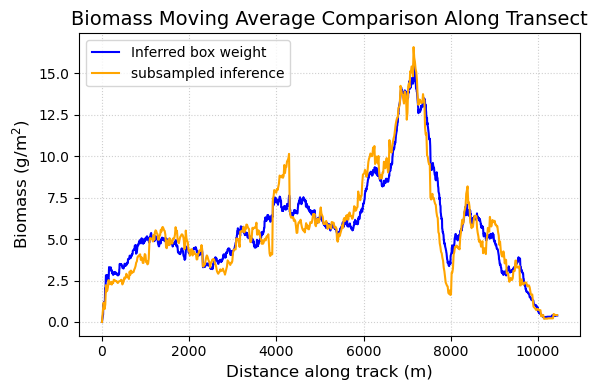

In [37]:
Transects.plot_biomass_comparison_moving_average(primary_transect=infer_biomass_df, secondary_transect=subsample_biomass_df, secondary_lbl="subsampled inference", secondary_window=round(100*frac))

analyzing 20240618_001_Iver3069_ABS2


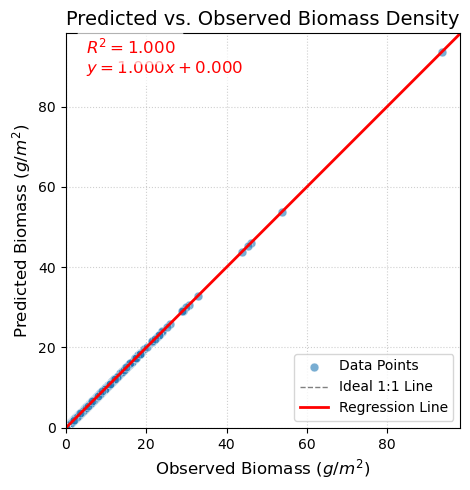

In [34]:
Transects.create_observed_vs_predicted_plot(infer_biomass_df, subsample_biomass_df)